# Multiple Basket Spreads Analysis

This notebook analyzes various spreads between PICNIC_BASKET1, PICNIC_BASKET2, and their components.

In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

# Add data_utils to path
sys.path.append(os.path.abspath('../data_utils'))
try:
    import util_minimal
    print("Successfully imported util_minimal")
except ImportError:
    print("Could not import util_minimal")

# Try to import backtester package
try:
    sys.path.append(os.path.abspath('../../'))
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester")

Successfully imported util_minimal
Successfully imported backtester.get_price_data


## 1. Load Data

First, let's load the price data for Round 2, focusing on PICNIC_BASKET1, PICNIC_BASKET2, and their components.

In [2]:
# Define products we need
products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']
product_data = {product: pd.DataFrame() for product in products}

# Try to load data using backtester package
has_data = False
try:
    for product in products:
        print(f"Loading {product} data using backtester...")
        product_data[product] = get_price_data(product, 2)
        print(f"Loaded {len(product_data[product])} rows of {product} data")
    has_data = all(len(data) > 0 for data in product_data.values())
    if has_data:
        print("Successfully loaded all required data using backtester")
except Exception as e:
    print(f"Error loading data using backtester: {e}")
    has_data = False

# If backtester package didn't work, try using util module
if not has_data:
    print("Trying to load data using util module...")
    try:
        reload(util_minimal)
        dm2p = util_minimal.load_all_price_data(2)
        print(f"Loaded {len(dm2p)} rows of data")
        
        # Display the first few rows
        print("\nFirst few rows of data:")
        display(dm2p.head())
        
        # Filter for each product
        for product in products:
            if product in dm2p['product'].unique():
                product_data[product] = dm2p[dm2p['product'] == product].copy()
                print(f"Filtered {len(product_data[product])} rows of {product} data")
            else:
                print(f"No {product} data found")
                product_data[product] = pd.DataFrame()
        
        has_data = all(len(data) > 0 for data in product_data.values())
        if has_data:
            print("Successfully loaded all required data using util module")
    except Exception as e:
        print(f"Error loading data using util module: {e}")
        has_data = False

Loading PICNIC_BASKET1 data using backtester...
Loading real data for PICNIC_BASKET1 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET1 data
Loading PICNIC_BASKET2 data using backtester...
Loading real data for PICNIC_BASKET2 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET2 data
Loading CROISSANTS data using backtester...
Loading real

## 2. Check Data Availability

Let's check if we have all the necessary data for our analysis.

In [3]:
# Check if we have all the necessary data
missing_products = [product for product in products if len(product_data[product]) == 0]

if missing_products:
    print(f"Missing data for the following products: {', '.join(missing_products)}")
    print("Cannot perform basket spread analysis without all required products.")
else:
    print("All required products are available for basket spread analysis.")
    
    # Display basic information about each product
    for product in products:
        data = product_data[product]
        print(f"\n{product} data:")
        print(f"Number of rows: {len(data)}")
        print(f"Columns: {', '.join(data.columns)}")

All required products are available for basket spread analysis.

PICNIC_BASKET1 data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap

PICNIC_BASKET2 data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap

CROISSANTS data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss, vwap

JAMS data:
Number of rows: 30000
Columns: day, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask

## 3. Calculate VWAP

Now let's calculate Volume-Weighted Average Price (VWAP) for each product, which we'll use for our spread analysis.

In [4]:
# Function to calculate VWAP for all products
def calculate_vwap(product_data):
    vwap_prices = {}
    for product, data in product_data.items():
        if len(data) > 0:
            try:
                # Try to use get_vwap from util_minimal if available
                vwap = util_minimal.get_vwap(data, product)
                vwap_prices[product] = vwap
                print(f"Calculated VWAP for {product} using util_minimal.get_vwap")
            except Exception as e:
                print(f"Error using util_minimal.get_vwap for {product}: {e}")
                
                # Calculate VWAP manually
                try:
                    # Calculate mid price if not already present
                    if 'mid_price' not in data.columns:
                        data['mid_price'] = (data['ask_price_1'] + data['bid_price_1']) / 2
                    
                    # Calculate volume if not already present
                    if 'total_volume' not in data.columns:
                        volume_cols = ['ask_volume_1', 'ask_volume_2', 'ask_volume_3', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3']
                        data['total_volume'] = data[volume_cols].sum(axis=1)
                    
                    # Calculate VWAP
                    data['price_volume'] = data['mid_price'] * data['total_volume']
                    
                    # Group by timestamp if available, otherwise use index
                    if 'timestamp' in data.columns:
                        data_grouped = data.groupby('timestamp')
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    else:
                        data_grouped = data.groupby(data.index)
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    
                    vwap_prices[product] = vwap
                    print(f"Calculated VWAP for {product} manually")
                except Exception as e:
                    print(f"Error calculating manual VWAP for {product}: {e}")
                    
                    # Fall back to mid price if VWAP calculation fails
                    if 'mid_price' in data.columns:
                        if 'timestamp' in data.columns:
                            vwap_prices[product] = data.set_index('timestamp')['mid_price']
                        else:
                            vwap_prices[product] = data['mid_price']
                        print(f"Falling back to mid price for {product}")
    
    return vwap_prices

# Calculate VWAP for all products
if has_data:
    try:
        vwap_prices = calculate_vwap(product_data)
        print(f"Calculated VWAP for {len(vwap_prices)} products")
        
        # Display the first few values of each VWAP series
        for product, prices in vwap_prices.items():
            print(f"\n{product} VWAP (first 5 values):")
            display(prices.head())
    except Exception as e:
        print(f"Error calculating VWAP: {e}")
else:
    print("Cannot calculate VWAP due to missing data")

Calculated VWAP for PICNIC_BASKET1 using util_minimal.get_vwap
Calculated VWAP for PICNIC_BASKET2 using util_minimal.get_vwap
Calculated VWAP for CROISSANTS using util_minimal.get_vwap
Calculated VWAP for JAMS using util_minimal.get_vwap
Calculated VWAP for DJEMBES using util_minimal.get_vwap
Calculated VWAP for 5 products

PICNIC_BASKET1 VWAP (first 5 values):


timestamp
0      59289.236842
100    59287.472973
200    59293.500000
300    59293.500000
400    59291.779412
dtype: float64


PICNIC_BASKET2 VWAP (first 5 values):


timestamp
0      30609.000000
100    30612.729730
200    30614.696970
300    30620.302326
400    30622.312500
dtype: float64


CROISSANTS VWAP (first 5 values):


timestamp
0      4304.5
100    4304.5
200    4304.5
300    4304.5
400    4305.5
dtype: float64


JAMS VWAP (first 5 values):


timestamp
0      6670.5
100    6670.5
200    6671.0
300    6672.0
400    6672.0
dtype: float64


DJEMBES VWAP (first 5 values):


timestamp
0      13450.500000
100    13450.000000
200    13450.196078
300    13450.000000
400    13452.500000
dtype: float64

## 4. Calculate Spreads

Now we'll calculate the various spreads between baskets and their components.

In [5]:
# Function to prepare price data for spread calculation
def prepare_price_data(vwap_prices):
    # Create a common index for all products
    all_indices = set()
    for product, prices in vwap_prices.items():
        all_indices.update(prices.index)
    common_index = sorted(all_indices)
    
    # Reindex all price series to the common index and forward fill missing values
    reindexed_prices = {}
    for product, prices in vwap_prices.items():
        reindexed_prices[product] = prices.reindex(common_index).ffill().bfill()
    
    return reindexed_prices, common_index

# Calculate the spreads
if has_data and 'vwap_prices' in locals():
    try:
        # Prepare price data
        reindexed_prices, common_index = prepare_price_data(vwap_prices)
        
        # Check if we have all required products
        required_products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']
        missing = [p for p in required_products if p not in reindexed_prices]
        
        if missing:
            print(f"Cannot calculate spreads. Missing prices for: {', '.join(missing)}")
        else:
            print("Successfully prepared price data for spread calculation")
            
            # Calculate theoretical basket values
            # PICNIC_BASKET1 = 6 × CROISSANTS + 3 × JAMS + 1 × DJEMBE
            theoretical_pb1 = (
                6 * reindexed_prices['CROISSANTS'] + 
                3 * reindexed_prices['JAMS'] + 
                1 * reindexed_prices['DJEMBES']
            )
            
            # PICNIC_BASKET2 = 4 × CROISSANTS + 2 × JAMS
            theoretical_pb2 = (
                4 * reindexed_prices['CROISSANTS'] + 
                2 * reindexed_prices['JAMS']
            )
            
            # Calculate spreads
            spreads = {}
            
            # 1. PICNIC_BASKET1 - base_assets
            spreads['pb1_minus_components'] = reindexed_prices['PICNIC_BASKET1'] - theoretical_pb1
            
            # 2. PICNIC_BASKET2 - base_assets
            spreads['pb2_minus_components'] = 1.5*(reindexed_prices['PICNIC_BASKET2'] - theoretical_pb2)
            
            # Display basic statistics about the first two spreads
            for name, spread in spreads.items():
                print(f"\n{name} statistics:")
                print(f"Mean: {spread.mean():.2f}")
                print(f"Median: {spread.median():.2f}")
                print(f"Min: {spread.min():.2f}")
                print(f"Max: {spread.max():.2f}")
                print(f"Standard deviation: {spread.std():.2f}")
                
                # Display the first few values of the spread
                print(f"\n{name} (first 5 values):")
                display(spread.head())
    except Exception as e:
        print(f"Error calculating spreads: {e}")
else:
    print("Cannot calculate spreads due to missing VWAP data")

Successfully prepared price data for spread calculation

pb1_minus_components statistics:
Mean: 48.76
Median: 50.86
Min: -194.83
Max: 248.47
Standard deviation: 85.10

pb1_minus_components (first 5 values):


timestamp
0      0.236842
100   -1.027027
200    3.303922
300    0.500000
400   -9.720588
dtype: float64


pb2_minus_components statistics:
Mean: 45.36
Median: 57.75
Min: -181.10
Max: 223.14
Standard deviation: 89.76

pb2_minus_components (first 5 values):


timestamp
0      75.000000
100    80.594595
200    82.045455
300    87.453488
400    84.468750
dtype: float64

In [6]:
# Calculate the more complex spreads
if has_data and 'vwap_prices' in locals() and 'reindexed_prices' in locals():
    try:
        # 3. 3*PICNIC_BASKET2 + 3*DJEMBES - 2*PICNIC_BASKET1
        spreads['1.5pb2_1djembes_minus_1pb1'] = (
            3 * reindexed_prices['PICNIC_BASKET2'] + 
            2 * reindexed_prices['DJEMBES'] - 
            2 * reindexed_prices['PICNIC_BASKET1']
        )/2
        
        # 4. 2*PICNIC_BASKET2 - 2*CROISSANTS - 1*JAMS + DJEMBES - PICNIC_BASKET1
        # spreads['1pb2_2croissants_1jams_plus_djembes_minus_pb1'] = (
        #     1 * reindexed_prices['PICNIC_BASKET2'] +
        #     2 * reindexed_prices['CROISSANTS'] +
        #     1 * reindexed_prices['JAMS'] +
        #     1* reindexed_prices['DJEMBES'] - 
        #     reindexed_prices['PICNIC_BASKET1']
        # )
        
        # Display statistics for the complex spreads
        for name in ['1.5pb2_1djembes_minus_1pb1']:
            spread = spreads[name]
            print(f"\n{name} statistics:")
            print(f"Mean: {spread.mean():.2f}")
            print(f"Median: {spread.median():.2f}")
            print(f"Min: {spread.min():.2f}")
            print(f"Max: {spread.max():.2f}")
            print(f"Standard deviation: {spread.std():.2f}")
            
            # Display the first few values of the spread
            print(f"\n{name} (first 5 values):")
            display(spread.head())
    except Exception as e:
        print(f"Error calculating complex spreads: {e}")
else:
    print("Cannot calculate complex spreads due to missing data")


1.5pb2_1djembes_minus_1pb1 statistics:
Mean: -3.40
Median: -13.42
Min: -204.35
Max: 267.38
Standard deviation: 93.50

1.5pb2_1djembes_minus_1pb1 (first 5 values):


timestamp
0      74.763158
100    81.621622
200    78.741533
300    86.953488
400    94.189338
dtype: float64

## 5. Visualize Spreads

Let's visualize all the spreads to better understand their behavior.

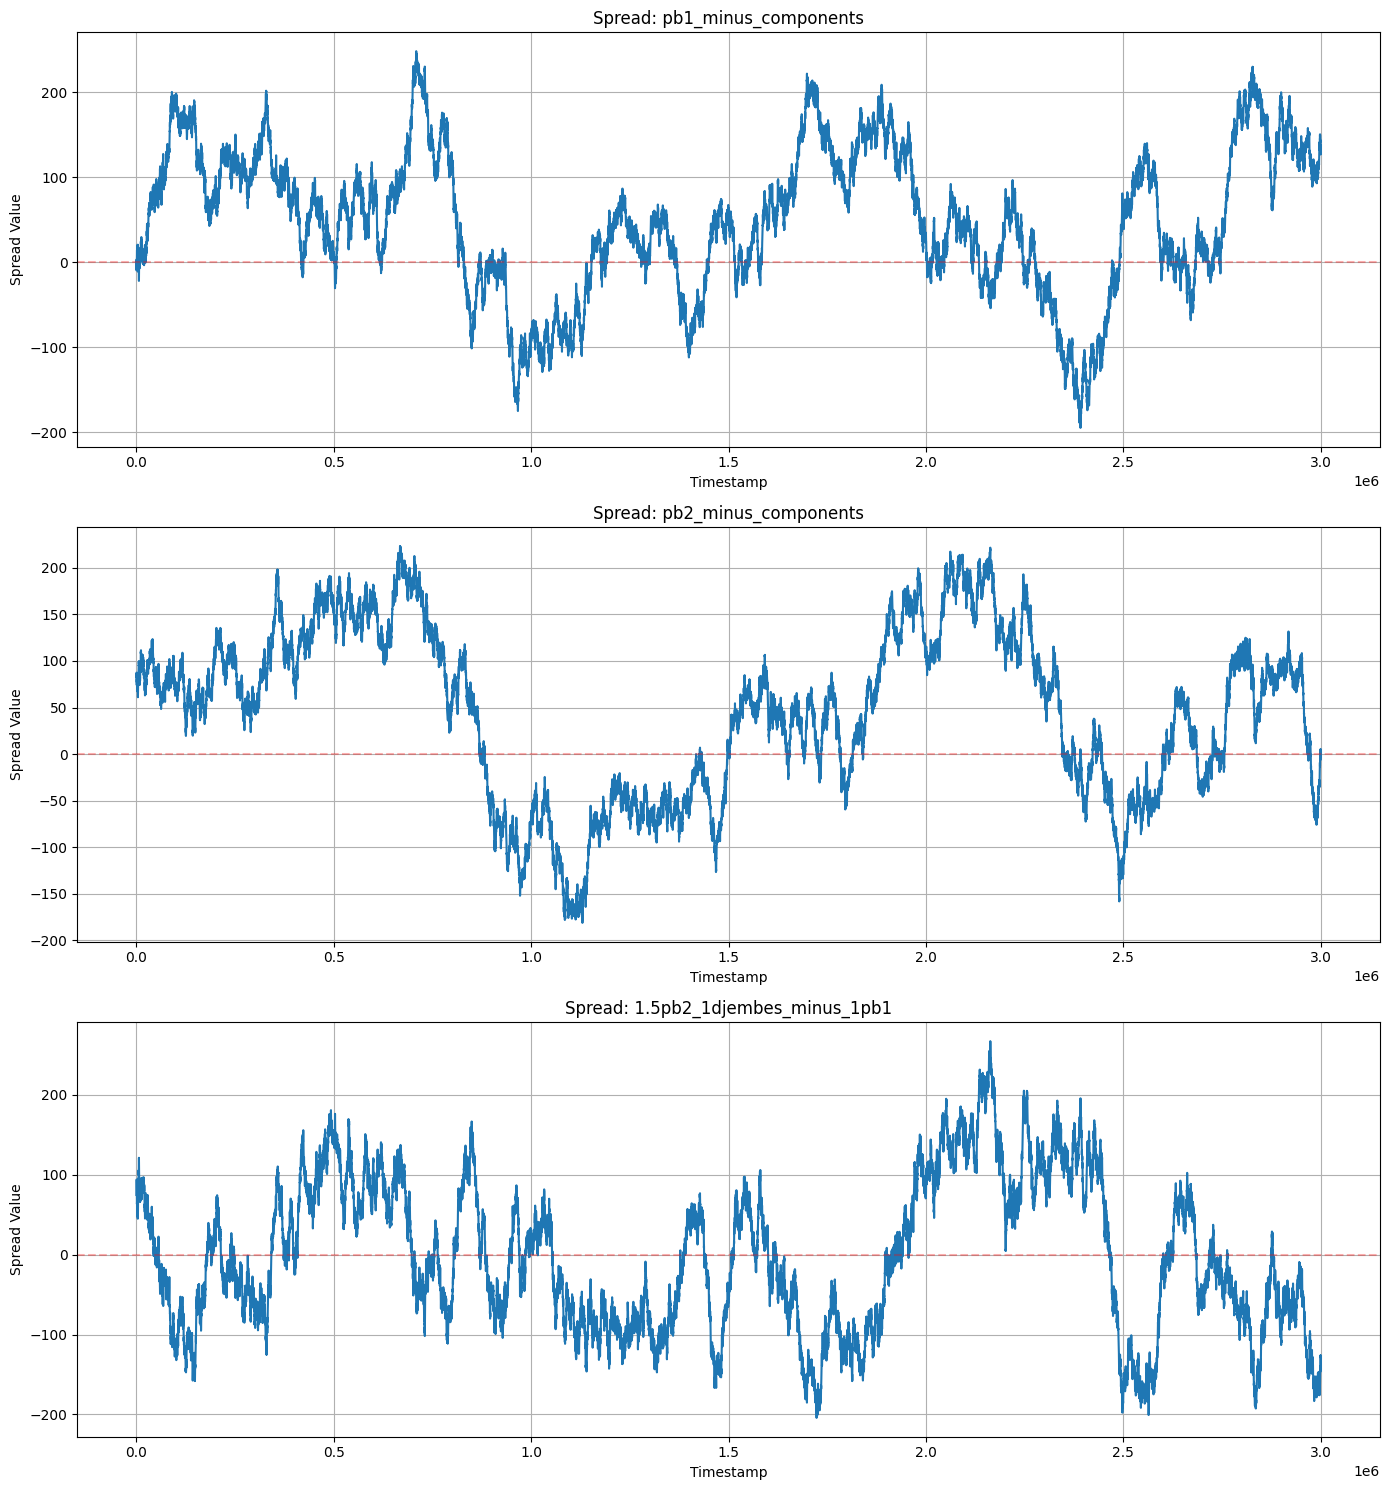

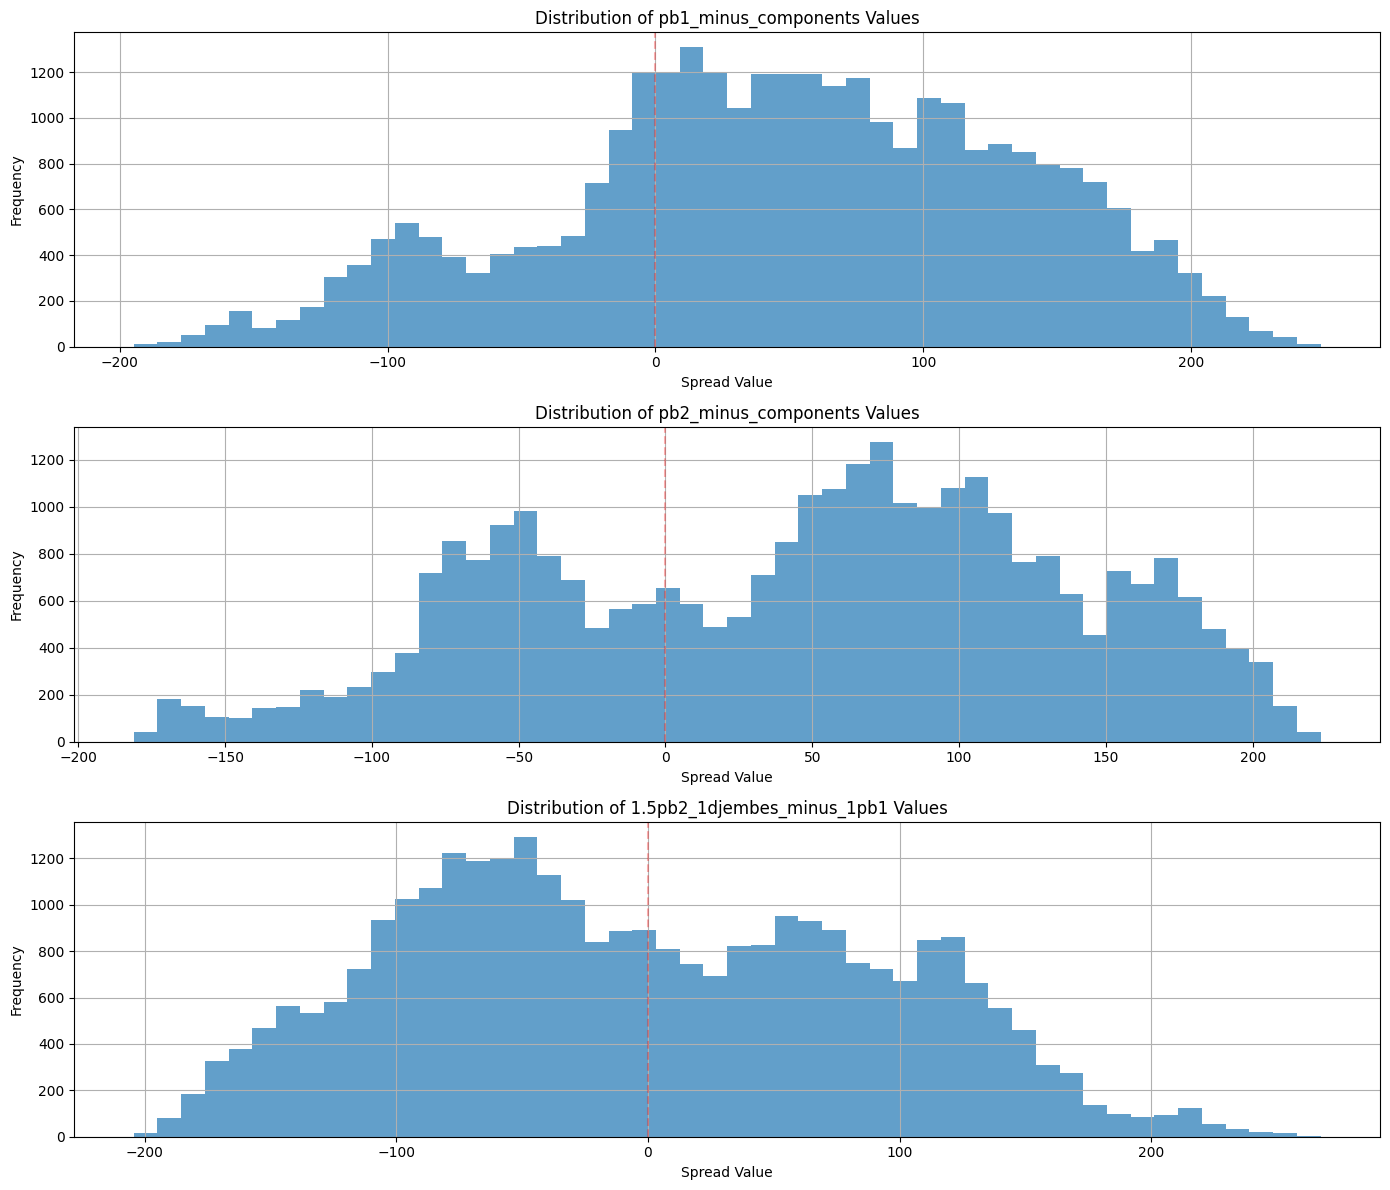

In [7]:
# Plot all spreads
if 'spreads' in locals() and len(spreads) > 0:
    # Create a figure with subplots
    fig, axs = plt.subplots(len(spreads), 1, figsize=(14, 5*len(spreads)))
    
    # Plot each spread
    for i, (name, spread) in enumerate(spreads.items()):
        ax = axs[i] if len(spreads) > 1 else axs
        ax.plot(spread.index, spread.values)
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        ax.set_title(f'Spread: {name}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Spread Value')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Create histograms of spread values
    fig, axs = plt.subplots(len(spreads), 1, figsize=(14, 4*len(spreads)))
    
    # Plot histogram for each spread
    for i, (name, spread) in enumerate(spreads.items()):
        ax = axs[i] if len(spreads) > 1 else axs
        ax.hist(spread.values, bins=50, alpha=0.7)
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.3)
        ax.set_title(f'Distribution of {name} Values')
        ax.set_xlabel('Spread Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No spreads available to visualize")

## 6. Compare Spreads

Let's compare all the spreads on the same plot to see their relative behavior.

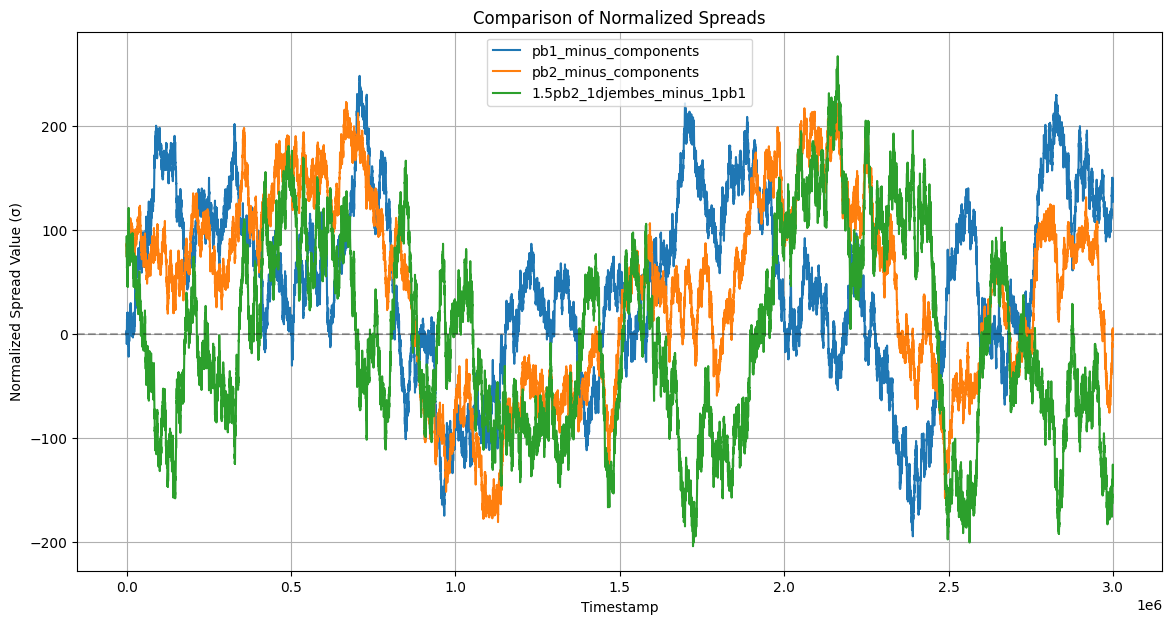

Correlation matrix between spreads:


,pb1_minus_components,pb2_minus_components,1.5pb2_1djembes_minus_1pb1
pb1_minus_components,1.000000,0.429120,-0.498186
pb2_minus_components,0.429120,1.000000,0.569398
1.5pb2_1djembes_minus_1pb1,-0.498186,0.569398,1.000000


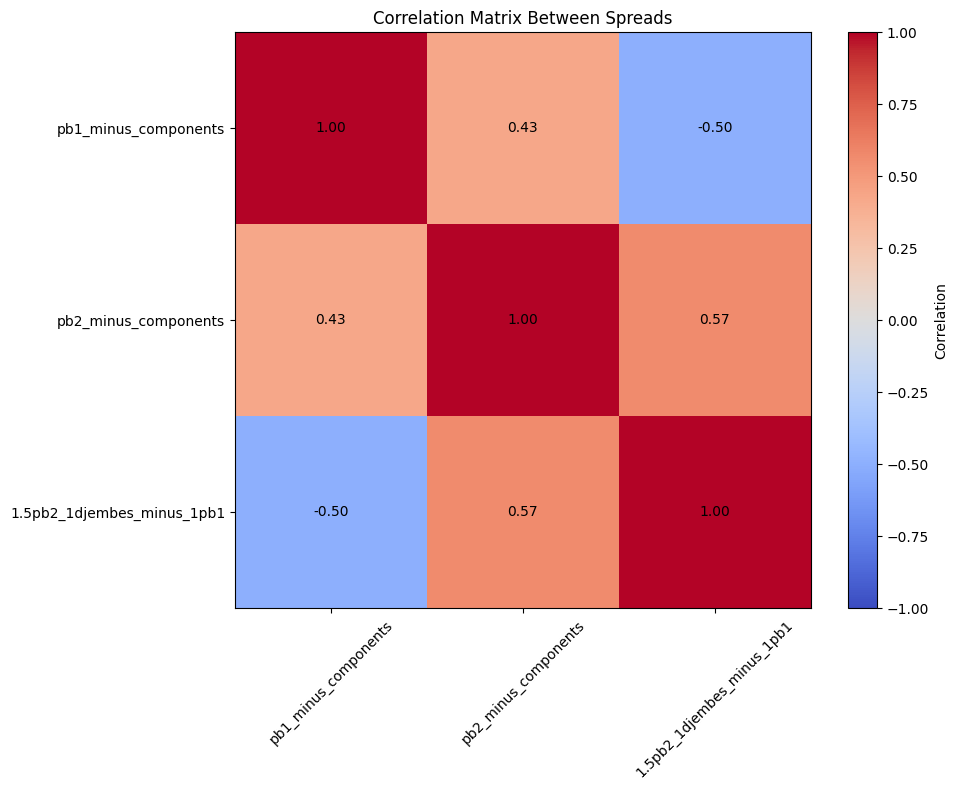

In [8]:
# Compare all spreads on the same plot
if 'spreads' in locals() and len(spreads) > 0:
    # Normalize spreads for better comparison
    normalized_spreads = {}
    for name, spread in spreads.items():
        # Normalize by standard deviation
        normalized_spreads[name] = spread
    
    # Plot all normalized spreads on the same plot
    plt.figure(figsize=(14, 7))
    for name, spread in normalized_spreads.items():
        plt.plot(spread.index, spread.values, label=name)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    plt.title('Comparison of Normalized Spreads')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Spread Value (σ)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate correlation matrix between spreads
    spread_df = pd.DataFrame(spreads)
    correlation_matrix = spread_df.corr()
    
    print("Correlation matrix between spreads:")
    display(correlation_matrix)
    
    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.title('Correlation Matrix Between Spreads')
    
    # Add correlation values to the heatmap
    for i in range(len(correlation_matrix)):
        for j in range(len(correlation_matrix)):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                     ha='center', va='center', color='black')
    
    plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
    plt.yticks(range(len(correlation_matrix)), correlation_matrix.index)
    plt.tight_layout()
    plt.show()
else:
    print("No spreads available to compare")

## 7. Conclusion

In this notebook, we analyzed various spreads between PICNIC_BASKET1, PICNIC_BASKET2, and their components:

1. PICNIC_BASKET1 - base_assets (theoretical value of components)
2. PICNIC_BASKET2 - base_assets (theoretical value of components)
3. 3*PICNIC_BASKET2 + 3*DJEMBES - 2*PICNIC_BASKET1
4. 2*PICNIC_BASKET2 - 2*CROISSANTS - 1*JAMS + DJEMBES - PICNIC_BASKET1

These spreads can help identify potential arbitrage opportunities between the baskets and their components. Significant deviations from zero in these spreads might indicate trading opportunities.